<a href="https://colab.research.google.com/github/Jorgecardetegit/NLP/blob/main/Grammatical_Error_Correction_with_HuggingFace%F0%9F%A4%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Grammatical Error Correction with HuggingFace 🤖**
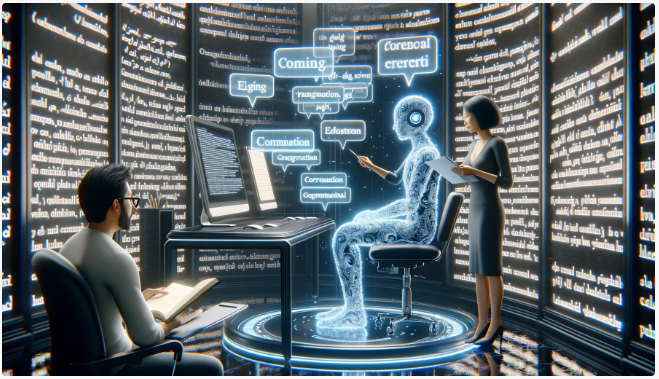
## **1. Overview**

Grammar correction is a crucial application of NLP, especially in tools designed for writers, students, and non-native speakers. The goal is to automatically detect and correct grammatical, punctuation, and spelling errors in written text.

#### **Types of Error**

- **Spelling:** Incorrect spelling of words (e.g., "recieve" instead of "receive").
- **Punctuation:** Misuse of punctuation marks (e.g., "Its raining" instead of "It's raining").
- **Syntax:** Errors in sentence structure (e.g., "She don't know" instead of "She doesn't know").
- **Usage:** Incorrect use of words or phrases (e.g., "affect" vs. "effect").
- **Agreement:** Subject-verb disagreement, pronoun reference errors, etc.

#### **Techniques and Approaches:**
 Early grammar checkers were primarily rule-based, where experts codified grammar rules into the system. With the rise of machine learning, statistical models were trained on large corpora to predict the likelihood of a sentence being grammatically correct. Deep learning models, especially recurrent neural networks (RNNs) and transformers, have been used to correct grammar by considering the context and sequence of words.

 ## **2. Model (T5)**

 T5, or "Text-to-Text Transfer Transformer", is a state-of-the-art model developed by Google Research for various Natural Language Processing (NLP) tasks.

#### **Concept**
 T5 is based on the idea that almost all NLP tasks can be cast as a text-to-text problem. Whether it's translation (translating English to French), summarization (long text to short text), or question-answering (question + context to answer), everything is treated as converting input text into target text.

 #### **Model Architecture**
- T5 uses the Transformer architecture using both the **encoder** and **decoder** stacks.

- T5 is **pre-trained** on a denoising autoencoder task. It learns to reconstruct a corrupted version of a text. This is akin to the "masked language modeling" task of BERT but applied to spans of tokens rather than individual tokens.

- For downstream tasks, T5 is **fine-tuned** on specific datasets, converting the task into a text-to-text format.

To know more about T5 visit the HuggingFace documentation or its orinigal paper:

https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/t5#overview

https://arxiv.org/pdf/1910.10683.pdf

## **3. Dataset (C4 200M)**

The dataset used for this proyect is the C4 200M HuggingFace dataset. c4_200m is a collection of 185 million sentence pairs generated from the cleaned English dataset from C4. This dataset can be used in grammatical error correction (GEC) tasks.

The dataset contains two columns "**input**", representing the raw sentence before passing it into the model and "**output**", representing the output sentence of the model.


# 1. Import libraries and install dependencies

In [ ]:
import importlib.util

# Function to check if a library is installed
def is_library_installed(name):
    spec = importlib.util.find_spec(name)
    return spec is not None

# Check if both 'transformers' and 'datasets' are installed
if not is_library_installed('transformers') or not is_library_installed('datasets') or not is_library_installed('sentencepiece') or not is_library_installed('evaluate') or not is_library_installed('sacrebleu'):
    !pip install transformers datasets sentencepiece evaluate sacrebleu

In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import io
import os
import re
import matplotlib.pyplot as plt### plotting bar chart
import string
import evaluate
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import create_optimizer,T5TokenizerFast,DataCollatorForSeq2Seq,TFT5ForConditionalGeneration,TFAutoModelForSeq2SeqLM,AutoModelForSeq2SeqLM,TFT5ForConditionalGeneration, AutoModelForSeq2SeqLM

# 2. Data preparation

In [ ]:
dataset_id="leslyarun/c4_200m_gec_train100k_test25k"
dataset = load_dataset(dataset_id)

#3. Basic EDA

In [8]:
print(dataset)

print(f"\nStructure of train dataset: {type(dataset['train'])}")

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 25000
    })
})

Structure of train dataset: <class 'datasets.arrow_dataset.Dataset'>


#### **Example:**

In [11]:
dataset["train"][5]

{'input': "Fairy Or Not, I'm the Godmother: no just look, but my outfit for taking the part as godmother.",
 'output': "Fairy Or Not, I'm the Godmother: Not just a look, but my outfit for taking on the role as godmother."}

# 4. Preprocessing

#### **Model for preprocessing**



In [ ]:
model_id="t5-small"
tokenizer=T5TokenizerFast.from_pretrained(model_id)

The **T5TokenizerFast** class is used to tokenize input text for the T5 (Text-to-Text Transfer Transformer) model, and it does so in a performant manner using the "fast" tokenizers based on **Rust**.

The "**Fast**" in T5TokenizerFast indicates that the tokenizer is backed by the tokenizers library, which is implemented in Rust for performance. Fast tokenizers are generally more performant than their Python counterparts and provide additional features, such as alignment between the original and tokenized text.

Once instantiated, the tokenizer can encode text, turning words into tokens or token IDs that the T5 model can understand.
It also can decode token IDs back into human-readable text.

Check: https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/t5#transformers.T5TokenizerFast

#### **Preprocessing function**

In [7]:
MAX_LENGTH = 128      # Maximum number of tokens allowed for the tokenized input.

def preprocess_function(examples):
  # Divides the 2 classes in the dataset
  inputs = [example for example in examples['input']]
  targets = [example for example in examples['output']]

  model_inputs = tokenizer(inputs, text_target=targets,max_length=MAX_LENGTH, truncation=True)    # truncation=True argument ensures that if an input has more tokens than MAX_LENGTH, it will be truncated down.
  return model_inputs

In [ ]:
tokenized_dataset=dataset.map(preprocess_function,batched=True,remove_columns=dataset["train"].column_names)


#5. Modelling

#### **Model (TFAutoModelForSeq2SeqLM.from_pretrained)**

- **Seq2Seq Architecture:** The underlying architecture of the model is designed for sequence-to-sequence tasks. This typically involves an encoder that processes the input sequence and a decoder that generates the output sequence.

- **Language Modeling Head:** The "LM" in ForSeq2SeqLM suggests that the decoder has a language modeling head. This means the decoder is designed to generate sequences token-by-token, often used in tasks like machine translation or text generation.

- **Flexibility:** By using the "Auto" class, you can load various seq2seq models available in the Hugging Face Model Hub, such as T5, BART, and more, without changing the code. The exact architecture is inferred from the model_id.

- **Pre-trained Weights:** The model comes with weights that have been pre-trained on a large corpus, allowing you to fine-tune it on a specific task with a smaller dataset and still achieve good performance.

- **TensorFlow model:** TF stands for TensorFlow, indicating that this is the TensorFlow version of the model.


Automodels documentation: https://huggingface.co/transformers/v3.0.2/model_doc/auto.html

#### **DataCollatorForSeq2Seq:**
Given that it's designed for sequence-to-sequence tasks, this data collator has specific functionalities tailored for such models:

- **Source and Target Sequences:** Sequence-to-sequence tasks involve both source (input) and target (output) sequences. This data collator handles both, ensuring they're correctly batched and preprocessed.

- **Tokenization:** The provided tokenizer is used to convert text into tokens or token IDs suitable for the model.

- **Padding:** It ensures that all sequences in a batch (both source and target) have consistent lengths by adding padding tokens.

- **Special Tokens:** Sequence-to-sequence models often require special tokens (e.g., start-of-sequence, end-of-sequence). The data collator ensures these are added as needed.

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_id)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,model=model, return_tensors="tf")

In [ ]:
# Converting to train and validation TF dataset

BATCH_SIZE = 64
train_dataset=tokenized_dataset["train"].to_tf_dataset(
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

val_dataset=tokenized_dataset["test"].to_tf_dataset(
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

#### **Example of a batch of the modified dataset**

In [26]:
for i in val_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(64, 98), dtype=int64, numpy=
array([[ 9139,   138,  2253, ...,     0,     0,     0],
       [ 9627,    37,  5791, ...,     0,     0,     0],
       [  116,    27,  4839, ...,     0,     0,     0],
       ...,
       [20255,  3535,     2, ...,     0,     0,     0],
       [10846,   670,    11, ...,     0,     0,     0],
       [ 1541,   132,    19, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(64, 98), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'labels': <tf.Tensor: shape=(64, 99), dtype=int64, numpy=
array([[   37, 13477,  2253, ...,  -100,  -100,  -100],
       [ 9627,    37,  5791, ...,  -100,  -100,  -100],
       [    3,    99,    27, ...,  -100,  -100,  -100],
       ...,
       [20255,  3535,     2, ...,  -100,  -100,  -100],
       [10846,   670

# 6. Model architecture

In [27]:
model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#  7. Training

I won´t be running this model because I don´t enough computation power, nevertheless you can run it and if you followed correctly the previous steps it will work.

If you also don´t have enough computation power you can reduce the number of epochs and batches or skip to the section 10 where I will be testing the results of a pretrained model in hugging face for grammatical error correction.

In [28]:
num_epochs = 5
num_train_steps=len(train_dataset)*num_epochs

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
)

# The number of training steps is the total number of batches that the model will see during training.

# Warmup steps are often used to gradually increase the learning rate from 0 to init_lr over a certain number of initial steps to ensure stable training.

In [ ]:
model.compile(optimizer=optimizer)

In [ ]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=num_epochs
)

# 8. Evaluation

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
metric = evaluate.load("sacrebleu")

In [ ]:
all_preds = []
all_labels = []

for batch in val_dataset.take(5):
  predictions = model.generate(
      input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
  )
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = batch["labels"].numpy()
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  all_preds.extend(decoded_preds)
  all_labels.extend(decoded_labels)

result = metric.compute(predictions=all_preds, references=all_labels)
print(result)

#9. Testing

In [ ]:
wrong_english=[
    "Dady hav'e eateing her foot",
    "DJ Sorryyouwastedyourmoneytobehere",
    "i used to like to swimming",
    "maybe we should organized a meetin with the people from unesco",
    "when are we goinge to start play football",
    "many a time rain fall in my city"
    ]
tokenized=tokenizer(
  wrong_english,
  padding="longest",
  max_length=MAX_LENGTH,
  truncation=True,
  return_tensors='tf'
)
out = model.generate(**tokenized, max_length=128)
print(out)

# 10. Saving the model

In [ ]:
location = "/content/drive/MyDrive/nlp/Gramatical error correction"
model.save(location)

#11. Testing on Pretrained Model (No FineTuning)

In [ ]:
pretrained_model=AutoModelForSeq2SeqLM.from_pretrained(
    "juancavallotti/t5-base-gec"
)

# Check the model in HuggingFace:
# https://huggingface.co/juancavallotti/t5-base-gec

In [12]:
wrong_english=[
    "Dady hav'e eateing her foot",
    "DJ Sorryyouwastedyourmoneytobehere",
    "i used to like to swimming",
    "maybe we should organized a meetin with the people from unesco",
    "when are we goinge to start play football",
    "many a time rain fall in my city",
   ]
tokenized=tokenizer(
  wrong_english,
  padding="longest",
  max_length=MAX_LENGTH,
  truncation=True,
  return_tensors='pt'
)
out=pretrained_model.generate(**tokenized, max_length=128)

In [13]:
for i in range(len(wrong_english)):
  print(wrong_english[i]+"------------>"+tokenizer.decode(out[i], skip_special_tokens=True))

Dady hav'e eateing her foot------------>Dady ate her foot.
DJ Sorryyouwastedyourmoneytobehere------------>DJ Sorry, you wasted your money,
i used to like to swimming------------>I used to like swimming.
maybe we should organized a meetin with the people from unesco------------>Maybe we should organize a meeting with the people from unesco.
when are we goinge to start play football------------>When are we going to start playing football
many a time rain fall in my city------------>Many a time rain falls in my city
